# Tracks of ARs in ERA5
### Get masks of ARs, remap to healpix
### Get HRRR data, remap to healpix
### Apply mask to HRRR data
### Create histogram of variables within the mask

Lexie Goldberger
05/12/25

In [1]:
import s3fs
import xarray as xr
import pandas as pd
import numpy as np
import pyproj
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import metpy
import datetime
import cartopy.crs as ccrs
from functools import partial
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [2]:
# Zoom level
s = '9'

# AR lat/lon mask 
root_dir = '/pscratch/sd/b/beharrop/people/for_lexie/'
in_mask_dir = f'{root_dir}ERA5_AR_tracks.nc'
print(in_mask_dir)

/pscratch/sd/b/beharrop/people/for_lexie/ERA5_AR_tracks.nc


In [3]:
# Open file
ds = xr.open_dataset(in_mask_dir)

Text(0.5, 1.0, '2019-08-13T12:00:00.000000000')

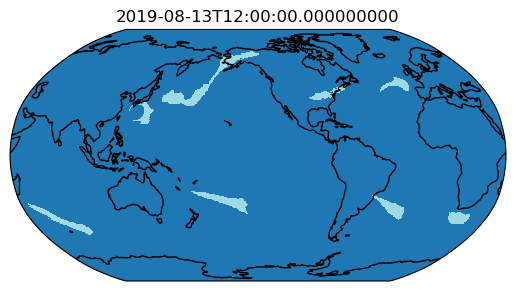

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
mask = ds.isel(time=50)['AR_binary_tag']
# Note: imshow does not consider lat/lon coordinates and may flip the image if 
# latitude is in ascending order. Use pcolormesh or contourf instead.

# Use Xarray pcolormesh
mask.plot(
    ax=ax, 
    vmin=0, vmax=1, cmap="tab20",
    transform=ccrs.PlateCarree(), add_colorbar=False,
)
# Setting extent explicitly doesn't seem to display full global view correctly
# ax.set_extent((0, 360, -90, 90), crs=ccrs.PlateCarree())
ax.coastlines()

plt.title(mask['time'].values)

## Limit just to conus for HRRR

In [5]:
print(ds['time'][0].values)
print(ds['time'][-1].values)

2019-08-01T00:00:00.000000000
2020-08-31T18:00:00.000000000


In [6]:
# Latitude [21.138123, 47.838623]
# Longitude [-122.719528, -72.289718]

In [7]:
subset = ds.sel(
    latitude=slice(47.838623,21.138123),  # From north to south
    longitude=slice(360-122.719528, 360-72.289718)  # From west to east
)

Text(0.5, 1.0, '2019-08-13T12:00:00.000000000')

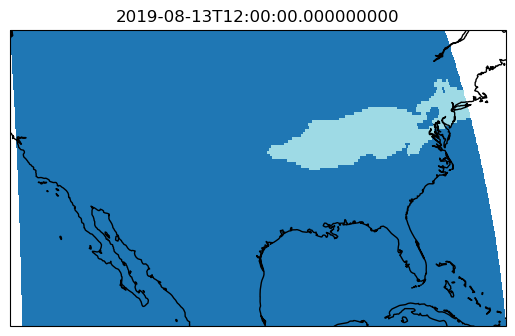

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
mask = subset.isel(time=50)['AR_binary_tag']
# Note: imshow does not consider lat/lon coordinates and may flip the image if 
# latitude is in ascending order. Use pcolormesh or contourf instead.

# Use Xarray pcolormesh
mask.plot(
    ax=ax, 
    vmin=0, vmax=1, cmap="tab20",
    transform=ccrs.PlateCarree(), add_colorbar=False,
)
# Setting extent explicitly doesn't seem to display full global view correctly
# ax.set_extent((0, 360, -90, 90), crs=ccrs.PlateCarree())
ax.coastlines()

plt.title(mask['time'].values)

## Get Data in Healpix catalog to map to

In [9]:
# List available catalogs
catalog_file = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"

list(intake.open_catalog(catalog_file))

['CN', 'EU', 'JAPAN', 'NCAR', 'NERSC', 'UK', 'online']

In [10]:
# Select a catalog for your location
current_location = "NERSC"
cat = intake.open_catalog(catalog_file)[current_location]
list(cat)

['ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_gl11',
 'obs',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'scream_ne120_inst',
 'tracking',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

In [11]:
# Make a flag for mask longitude sign
signed_lon = True if np.min(mask.longitude) < 0 else False
print(f"Mask lon coordinate has negative values: {signed_lon}")

Mask lon coordinate has negative values: False


In [12]:
pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",2


In [13]:
%%time
# Get OLR/precip data from catalog
catalog_params = {'zoom': 9}  # Can have multiple parameters

# Note the use of **catalog_params to pass the parameters
ds_hp = cat['scream2D_hrly'](**catalog_params).to_dask()

# Add lat/lon coordinates to the DataSet.
# Set signed_lon=True for matching lat/lon DataSet with longitude -180 to +180
ds_hp = ds_hp.pipe(partial(egh.attach_coords,signed_lon=signed_lon))
ds_hp

CPU times: user 253 ms, sys: 112 ms, total: 365 ms
Wall time: 515 ms


<xarray.Dataset> Size: 238GB
Dimensions:   (time: 9457, cell: 3145728)
Coordinates:
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    lat       (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon       (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    crs       int64 8B 0
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Data variables:
    pr        (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ELEV      (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [14]:
# Assign extra coordinates (lon_hp, lat_hp) to the HEALPix coordinates
# This is needed for limiting the extrapolation during remapping
lon_hp = ds_hp.lon.assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = ds_hp.lat.assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)
lat_hp

<xarray.DataArray 'lat' (cell: 3145728)> Size: 25MB
array([ 0.0746039 ,  0.14920793,  0.14920793, ..., -0.14920793,
       -0.14920793, -0.0746039 ], shape=(3145728,))
Coordinates:
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat_hp   (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
Attributes:
    units:          degree_north
    standard_name:  latitude
    axis:           Y

## Convert to HealPix

In [15]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon", roll=False):
    """
    Fix coordinates in a dataset:
    1. Convert longitude from -180/+180 to 0-360 range (optional)
    2. Roll dataset to start at longitude 0 (optional)
    3. Ensure coordinates are in ascending order
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with lat/lon coordinates
    lat_dim : str, optional
        Name of latitude dimension, default "lat"
    lon_dim : str, optional
        Name of longitude dimension, default "lon"
    roll : bool, optional, default=False
        If True, convert longitude from -180/+180 to 0-360, and roll the dataset to start at longitude 0
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with fixed coordinates
    """
    if roll:
        # Find where longitude crosses from negative to positive (approx. where lon=0)
        lon_0_index = (ds[lon_dim] < 0).sum().item()
        
        # Create indexers for the roll
        lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
        
        # Roll dataset and convert longitudes to 0-360 range
        ds = ds.isel({lon_dim: lon_indices})
        lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
        ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds

def is_valid(ds, tolerance=0.1):
    """
    Limit extrapolation distance to a certain tolerance.
    This is useful for preventing extrapolation of regional data to global HEALPix grid.

    Args:
        ds (xarray.Dataset):
            The dataset containing latitude and longitude coordinates.
        tolerance (float): default=0.1
            The maximum allowed distance in [degrees] for extrapolation.

    Returns:
        xarray.DataSet.
    """
    return (np.abs(ds.lat - ds.lat_hp) < tolerance) & (np.abs(ds.lon - ds.lon_hp) < tolerance)

In [16]:
# Apply function to fix  mask dataset coordinates
ds_mask = mask
ds_mask = ds_mask.rename({'longitude': 'lon','latitude': 'lat'})
ds_mask.pipe(fix_coords)

<xarray.DataArray 'AR_binary_tag' (lat: 107, lon: 201)> Size: 86kB
[21507 values with dtype=int32]
Coordinates:
    time     datetime64[ns] 8B 2019-08-13T12:00:00
  * lat      (lat) float64 856B 21.25 21.5 21.75 22.0 ... 47.0 47.25 47.5 47.75
  * lon      (lon) float64 2kB 237.5 237.8 238.0 238.2 ... 287.0 287.2 287.5

In [17]:
%%time
# Remap mask DataSet to HEALPix
ds_mask_hp = ds_mask.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=0.1))
# Drop unnecessary coordinates
ds_mask_hp = ds_mask_hp.drop_vars(["lat_hp", "lon_hp"])
ds_mask_hp

CPU times: user 716 ms, sys: 184 ms, total: 900 ms
Wall time: 899 ms


<xarray.DataArray 'AR_binary_tag' (cell: 3145728)> Size: 25MB
array([nan, nan, nan, ..., nan, nan, nan], shape=(3145728,))
Coordinates:
    time     datetime64[ns] 8B 2019-08-13T12:00:00
    lat      (cell) float64 25MB 21.25 21.25 21.25 21.25 ... 21.25 21.25 21.25
    lon      (cell) float64 25MB 237.5 237.5 237.5 237.5 ... 287.5 287.5 287.5
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727

In [18]:
%%time
# Remap mask DataSet to HEALPix
ds_mask_hp = ds_mask.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=0.1))
# Drop unnecessary coordinates
ds_mask_hp = ds_mask_hp.drop_vars(["lat_hp", "lon_hp"])
ds_mask_hp

CPU times: user 737 ms, sys: 116 ms, total: 853 ms
Wall time: 851 ms


<xarray.DataArray 'AR_binary_tag' (cell: 3145728)> Size: 25MB
array([nan, nan, nan, ..., nan, nan, nan], shape=(3145728,))
Coordinates:
    time     datetime64[ns] 8B 2019-08-13T12:00:00
    lat      (cell) float64 25MB 21.25 21.25 21.25 21.25 ... 21.25 21.25 21.25
    lon      (cell) float64 25MB 237.5 237.5 237.5 237.5 ... 287.5 287.5 287.5
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727

Text(0.5, 1.0, 'AR mask healpix')

<Figure size 640x480 with 0 Axes>

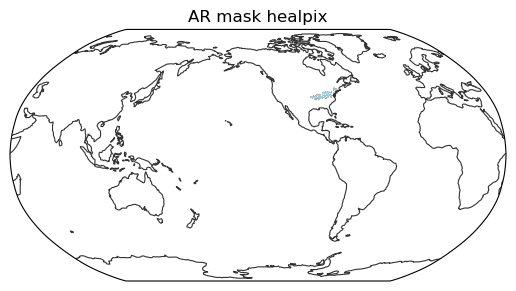

In [19]:
ar_mask_hp = ds_mask_hp

img = egh.healpix_show(ar_mask_hp.where(ar_mask_hp!=0), vmin=0, vmax=1, cmap="tab20")
plt.title("AR mask healpix")

## Get our HRRR Data and plot it too

In [20]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path):
    return s3fs.S3Map(path, s3=s3)

In [21]:
dt = np.datetime64(ds['time'][50].values)
ts = pd.Timestamp(dt)

formatted_str = ts.strftime('%Y%m%d_%H')
print(formatted_str) 

20190813_12


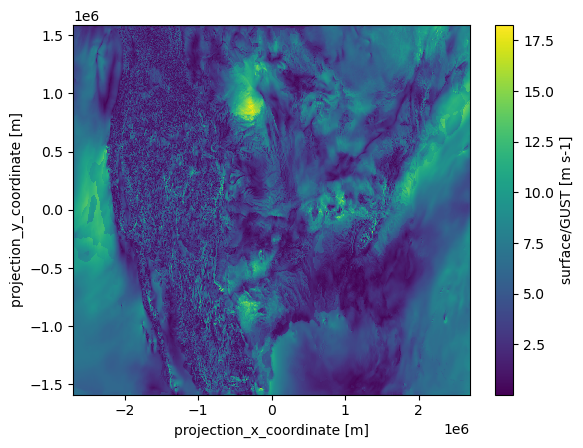

In [22]:
path = f"hrrrzarr/sfc/{formatted_str[0:8]}/{formatted_str}z_anl.zarr/surface/GUST"
dshrrr = xr.open_mfdataset([lookup(path), lookup(f"{path}/surface")],engine="zarr") 
list(dshrrr.keys())
dshrrr.GUST.plot()

In [23]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

In [24]:
%%time
year = (ts.year)
month = (ts.month)
day = (ts.day)
hour = (ts.hour)
dshrrr = load_combined_dataset(datetime.datetime(year, month, day), hour+1, "surface", "GUST")

CPU times: user 3.77 s, sys: 43.9 ms, total: 3.81 s
Wall time: 9.82 s


In [25]:
ds_hrrr_sel = dshrrr.sel(time=np.datetime64(datetime.datetime(year, month, day,hour)))
ds_hrrr_sel

<xarray.Dataset> Size: 34MB
Dimensions:                  (y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
    time                     datetime64[ns] 8B 2019-08-13T12:00:00
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 15MB 21.14 21.15 ... 47.85 47.84
    longitude                (y, x) float64 15MB -122.7 -122.7 ... -60.95 -60.92
Data variables:
    forecast_period          timedelta64[ns] 8B 00:00:00
    forecast_reference_time  datetime64[ns] 8B 2019-08-13T12:00:00
    height                   float64 8B 1e+03
    pressure                 float64 8B 2.5e+04
    GUST                     (y, x) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>

In [26]:
ds_hrrr_sel['GUST']

<xarray.DataArray 'GUST' (y: 1059, x: 1799)> Size: 4MB
dask.array<getitem, shape=(1059, 1799), dtype=float16, chunksize=(150, 150), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 14kB -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y          (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
    time       datetime64[ns] 8B 2019-08-13T12:00:00
    metpy_crs  object 8B Projection: lambert_conformal_conic
    latitude   (y, x) float64 15MB 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude  (y, x) float64 15MB -122.7 -122.7 -122.7 ... -60.99 -60.95 -60.92
Attributes:
    GRIB_PARAM:  [2, 0, 2, 22]
    long_name:   surface/GUST
    units:       m s-1

In [27]:
da = ds_hrrr_sel['GUST']

# Extract and rename 1D coordinates
lat_1d = xr.DataArray(da['latitude'][:, 0].values, dims='latitude')
lon_1d = xr.DataArray(da['longitude'][0, :].values, dims='longitude')

# Create a new DataArray with dimensions (latitude, longitude)
new_da = xr.DataArray(
    data=da.values,
    dims=('latitude', 'longitude'),
    coords={
        'latitude': lat_1d,
        'longitude': lon_1d
    },
    attrs=da.attrs
)

new_da

<xarray.DataArray (latitude: 1059, longitude: 1799)> Size: 4MB
array([[6.83 , 6.89 , 6.89 , ..., 8.766, 8.766, 8.83 ],
       [6.766, 6.953, 7.016, ..., 8.64 , 8.7  , 8.766],
       [6.766, 6.89 , 6.953, ..., 8.7  , 8.766, 8.83 ],
       ...,
       [3.453, 3.578, 3.578, ..., 7.766, 7.89 , 8.016],
       [3.328, 3.453, 3.516, ..., 7.766, 7.89 , 8.08 ],
       [3.203, 3.266, 3.266, ..., 7.83 , 7.953, 8.08 ]],
      shape=(1059, 1799), dtype=float16)
Coordinates:
  * latitude   (latitude) float64 8kB 21.14 21.16 21.19 ... 47.79 47.81 47.84
  * longitude  (longitude) float64 14kB -122.7 -122.7 -122.7 ... -72.32 -72.29
Attributes:
    GRIB_PARAM:  [2, 0, 2, 22]
    long_name:   surface/GUST
    units:       m s-1

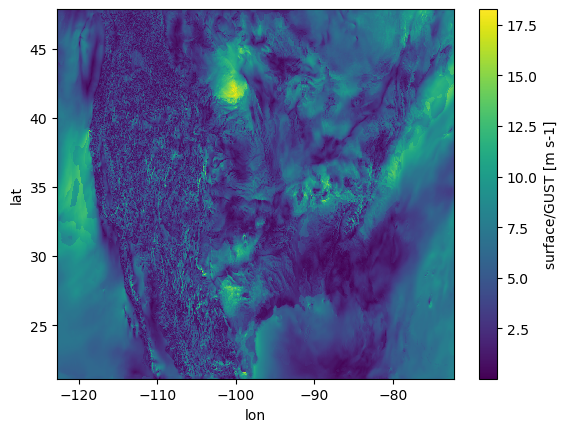

In [28]:
new_da = new_da.rename({'latitude': 'lat', 'longitude': 'lon'})
new_da.plot()

In [34]:
ds_to_turn = new_da

# Make a flag for mask longitude sign
signed_lon = True if np.min(ds_to_turn.lon) < 0 else False
print(f"Mask lon coordinate has negative values: {signed_lon}")

#


# Get OLR/precip data from catalog
catalog_params = {'zoom': 9}  # Can have multiple parameters

# Note the use of **catalog_params to pass the parameters
ds_hp = cat['scream2D_hrly'](**catalog_params).to_dask()

# Add lat/lon coordinates to the DataSet.
# Set signed_lon=True for matching lat/lon DataSet with longitude -180 to +180
ds_hp = ds_hp.pipe(partial(egh.attach_coords,signed_lon=signed_lon))
ds_hp

#

# Assign extra coordinates (lon_hp, lat_hp) to the HEALPix coordinates
# This is needed for limiting the extrapolation during remapping
lon_hp = ds_hp.lon.assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = ds_hp.lat.assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)

#


# Apply function to fix  mask dataset coordinates
#ds_to_turn = ds_to_turn.rename({'longitude': 'lon','latitude': 'lat'})
ds_to_turn.pipe(fix_coords)

#


# Remap mask DataSet to HEALPix
ds_hp = ds_to_turn.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=0.1))
# Drop unnecessary coordinates
ds_hp = ds_hp.drop_vars(["lat_hp", "lon_hp"])
ds_hp

Mask lon coordinate has negative values: True


<xarray.DataArray (cell: 3145728)> Size: 6MB
array([nan, nan, nan, ..., nan, nan, nan], shape=(3145728,), dtype=float16)
Coordinates:
    lat      (cell) float64 25MB 21.14 21.14 21.14 21.14 ... 21.14 21.14 21.14
    lon      (cell) float64 25MB -72.29 -72.29 -72.29 ... -72.29 -72.29 -72.29
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Attributes:
    GRIB_PARAM:  [2, 0, 2, 22]
    long_name:   surface/GUST
    units:       m s-1

## Visualize and apply mask in healpix

Text(0.5, 1.0, 'HRRR healpix')

<Figure size 640x480 with 0 Axes>

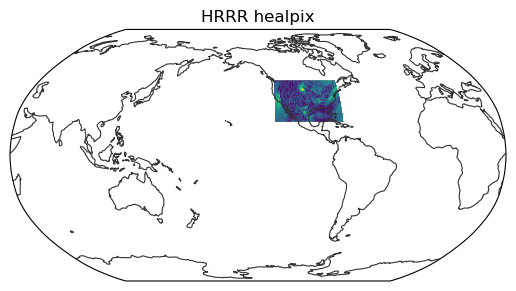

In [35]:
img = egh.healpix_show(ds_hp)
plt.title("HRRR healpix")

Text(0.5, 1.0, 'HRRR with AR mask healpix')

<Figure size 640x480 with 0 Axes>

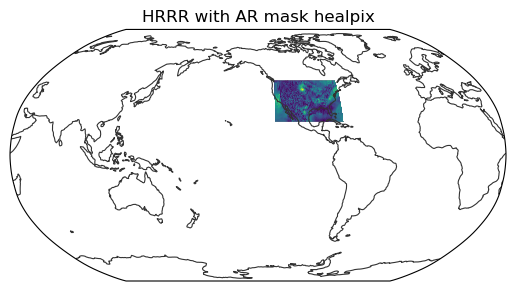

In [36]:
img1 = egh.healpix_show(ar_mask_hp.where(ar_mask_hp!=0), vmin=0, vmax=1, cmap="tab20")
img2 = egh.healpix_show(ds_hp)
plt.title("HRRR with AR mask healpix")

<Figure size 640x480 with 0 Axes>

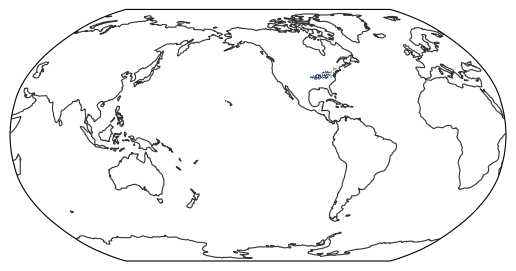

In [38]:
masked = ds_hp.where(ar_mask_hp > 0.5)

img2 = egh.healpix_show(masked)

In [54]:
# masked is an numpy.ndarray
data = masked.values
AR = data[~np.isnan(data)]
AR

array([3.328, 3.828, 2.578, ..., 4.39 , 4.766, 5.33 ],
      shape=(2815,), dtype=float16)

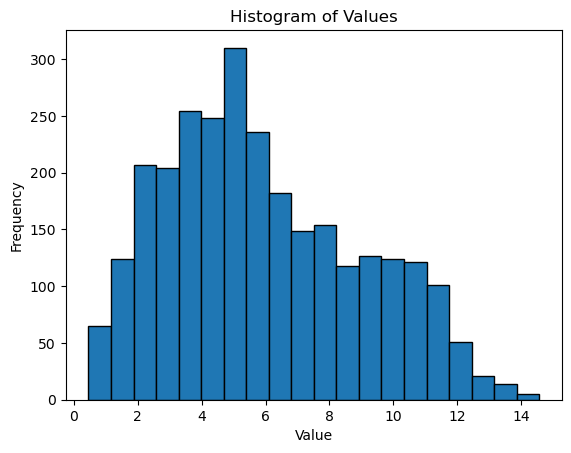

In [55]:
# Plot histogram
plt.hist(AR, bins=20, edgecolor='black')
plt.title("Histogram of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()